<a href="https://colab.research.google.com/github/seungyeoniii/neuroimaging/blob/main/amyloidPET_CNNclassifier_LRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

In [ ]:
!unzip -qq "/content/grey_matter.zip" -d "/content/grey_matter"

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
def StandardScalingData(data, save_path=None, keep_dim=True, train=True, scaler=None):
    data = np.array(data).astype(np.float32)
    flattened_data = [d.flatten() for d in data]
    if train is True:
        scaler = StandardScaler()
        scaler.fit(flattened_data)
        scaled_data = scaler.transform(flattened_data)
        if save_path :
            save_sk_model(scaler, save_path)
    else :
        if save_path :
            scaler = load_sk_model(save_path)
        scaled_data = scaler.transform(flattened_data)

    print("scaled_data", scaled_data.shape)

    if keep_dim is True:
        return scaler, scaled_data.reshape(data.shape)
    else:
        return scaler, scaled_data

def save_sk_model(model, save_path):
    try:
        joblib.dump(model, save_path)
    except FileNotFoundError as fnfe:
        print(fnfe)
        return False
    return True

def load_sk_model(save_path):
    model = joblib.load(save_path)
    return model

# 뇌영상
아밀로이드 PET, 알츠하이머병 진단시 보조 진단 도구로 사용됨.

In [ ]:
data_dir = '/content/grey_matter'

child_dirs = os.listdir(data_dir)
child_dirs.sort()
data_dir_child_path = [os.path.join(data_dir, child) for child in child_dirs]
print("data_dir_child_path", data_dir_child_path)

_label = []
_data_filename = []

for ind, class_dir in enumerate(data_dir_child_path):
    print("debug load3DImage, read class_dir data", ind, class_dir)
    nii_files = os.listdir(class_dir)
    nii_paths = [os.path.join(class_dir, nii) for nii in nii_files]
    for i, path in enumerate(nii_paths):
        if os.path.basename(path) == '.ipynb_checkpoints':
            continue
        elif os.path.basename(path) == 'desktop.ini':
            continue
        img_nii = np.load(path) # (64,64,64,1)
        img_nii = np.transpose(img_nii, (3,0,1,2)) # (C, D, ?, ?) H, W? W, H?
        _data_filename.append([img_nii, os.path.basename(path)[:-4]])  # 0: img, 1:filename
        gr_name = os.path.basename(class_dir)
        _label.append(int(gr_name))

data_dir_child_path ['/content/grey_matter/.ipynb_checkpoints', '/content/grey_matter/0', '/content/grey_matter/1']
debug load3DImage, read class_dir data 0 /content/grey_matter/.ipynb_checkpoints
debug load3DImage, read class_dir data 1 /content/grey_matter/0
debug load3DImage, read class_dir data 2 /content/grey_matter/1


In [ ]:
_data_filename = np.array(_data_filename)
print('_data_filename.shape', _data_filename.shape)
_label = np.array(_label, dtype=np.uint8)
print('_label.shape', _label.shape)
print()
print()
# Check / 0: img, 1:filename
print('_data_filename[0,0].shape', _data_filename[0,0].shape) # (C,D,H,W)
print('_data_filename[0,1]', _data_filename[0,1])

_data_filename.shape (234, 2)
_label.shape (234,)


_data_filename[0,0].shape (1, 64, 64, 64)
_data_filename[0,1] FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0061_preprocessed


# npy to tensor

In [ ]:
X_train_val_tensor = np.array([_data_filename[:,0][i] for i in range(len(_data_filename))])
print(X_train_val_tensor.shape)

X_train_val_tensor = torch.Tensor(X_train_val_tensor)
y_train_val_tensor = torch.Tensor(_label)
y_train_val_tensor = y_train_val_tensor.type(torch.FloatTensor)
print(y_train_val_tensor)

(234, 1, 64, 64, 64)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.,

# Model structure & training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, block_inplanes=[8,16,32]):
        super().__init__()

        self.conv1 = nn.Conv3d(block_inplanes[0],block_inplanes[1],kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1 = nn.BatchNorm3d(block_inplanes[1])
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(block_inplanes[1],block_inplanes[2],kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm3d(block_inplanes[2])
        self.downsample = nn.Conv3d(block_inplanes[0],block_inplanes[2],kernel_size=1,stride=1,bias=False)
        self.downsample_bn1 = nn.BatchNorm3d(block_inplanes[2])

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        residual = self.downsample(x)
        residual = self.downsample_bn1(residual)

        out += residual
        out = self.relu(out)

        return out

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv3d(1, 8, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
        self.bn1 = nn.BatchNorm3d(8)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.maxpool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.maxpool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.bblock1 = BasicBlock(block_inplanes=[8,16,32])
        self.bblock2 = BasicBlock(block_inplanes=[32,64,128])
        self.bblock3 = BasicBlock(block_inplanes=[128,256,512])
        self.fc1 = nn.Linear(32768, 2) #nn.Linear(65536, 2)
        self.fc2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        # x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.bblock1(x)
        x = self.maxpool2(x)
        x = self.bblock2(x)
        x = self.maxpool3(x)
        x = self.bblock3(x)
        # # # x = self.maxpool(x)
        # # # x = self.bblock4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [ ]:
from torchsummary import summary
test_model = Model().to(torch.device(device))
summary(test_model, (1,64,64,64))
# torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 32, 32, 32]           2,752
       BatchNorm3d-2        [-1, 8, 32, 32, 32]              16
              ReLU-3        [-1, 8, 32, 32, 32]               0
         MaxPool3d-4        [-1, 8, 16, 16, 16]               0
            Conv3d-5       [-1, 16, 16, 16, 16]           3,456
       BatchNorm3d-6       [-1, 16, 16, 16, 16]              32
              ReLU-7       [-1, 16, 16, 16, 16]               0
            Conv3d-8       [-1, 32, 16, 16, 16]          13,824
       BatchNorm3d-9       [-1, 32, 16, 16, 16]              64
           Conv3d-10       [-1, 32, 16, 16, 16]             256
      BatchNorm3d-11       [-1, 32, 16, 16, 16]              64
             ReLU-12       [-1, 32, 16, 16, 16]               0
       BasicBlock-13       [-1, 32, 16, 16, 16]               0
        MaxPool3d-14          [-1, 32, 

# Training

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=4, test_size=.25, random_state=24)
epochs = 100
val_index_list = []
valloader_list= []
# train_val_set
for ind, (train_index, val_index) in enumerate(splitter.split(X_train_val_tensor, y_train_val_tensor)):
    print("Fold #{}".format(ind+1))
    print("train", len(train_index))
    print("val", len(val_index))
    val_index_list.append(val_index)
    
    pos_count = y_train_val_tensor[train_index].tolist().count(1)
    neg_count = y_train_val_tensor[train_index].tolist().count(0)
    weight_for_1 = (neg_count+pos_count)/(2*pos_count)
    print('weight_for_1', weight_for_1)
    weight = [weight_for_1]
    class_weight = torch.FloatTensor(weight).to(device)

    save_path = os.path.join('/content/folds', 'fold'+str(ind+1)+'_scaler.pkl')
    scaler, X_train = StandardScalingData(data=X_train_val_tensor[train_index], save_path=save_path)
    X_train = torch.Tensor(X_train)
    train_set = TensorDataset(X_train, y_train_val_tensor[train_index])

    _, X_val = StandardScalingData(data=X_train_val_tensor[val_index], train=False, scaler=scaler)
    X_val = torch.Tensor(X_val)
    val_set = TensorDataset(X_val, y_train_val_tensor[val_index])

    trainloader = DataLoader(train_set, batch_size=8)
    valloader = DataLoader(val_set, batch_size=8)

    val_save_path = os.path.join('/content/folds', 'fold'+str(ind+1)+'_valloader.pt')
    torch.save(valloader, val_save_path)

    model = Model().to(device)

    criterion = nn.BCELoss(weight=class_weight).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
    min_val_loss = 0
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            print('[epoch: %d, %5d / %d] loss: %.7f' % (epoch, 10*(batch_idx+1), len(train_index), running_loss))
            running_loss = 0.0

        correct = 0
        total = 0
        confusion_matrix = torch.zeros(2,2)
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch_idx, (inputs, labels) in enumerate(valloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs) # (B, 1)
                v_loss = criterion(outputs, labels.unsqueeze(1))
                # _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                predicted = outputs.data.detach()
                # predicted_y.append(predicted.cpu().numpy().tolist()) # (B,1)
                predicted = predicted > 0.5
                correct +=(labels.unsqueeze(1) == predicted).sum().item()
                val_loss += v_loss.item()
                for t, p in zip(labels.unsqueeze(1).view(-1), predicted.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

        fname = 'cv'+ str(ind+1) + '_' + 'epochs' + str(epoch) + '_val_loss' + '{0:0.3f}'.format(val_loss) + '_model.pt'
        torch.save(model.state_dict(), os.path.join("./mymodel", fname))
        print('[epoch: %d] Accuracy of the network on the validation images: %d %% [ %d / %d ], val_loss: %.7f' % (epoch, 100*correct/total, correct, total, val_loss))
        print(confusion_matrix)
        print('\n')

# External validation

In [ ]:
# _, X_val = StandardScalingData(data=X_train_val_tensor, train=False, save_path='fold2_scaler.pkl')
# X_val = torch.Tensor(X_val)
# val_set = TensorDataset(X_val, y_train_val_tensor)
# fold2_valloader = DataLoader(val_set, batch_size=8)

scaled_data (48, 262144)


In [ ]:
fold2_valloader = torch.load('/content/folds/fold2_valloader.pt')

In [ ]:
from sklearn.metrics import confusion_matrix

path = '/content/mymodel/cv2_epochs100_val_loss3.268_model.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

test_model = Model().to(device)
test_model.load_state_dict(torch.load(path))
test_model.eval()
test_loss = 0
correct = 0
total = 0

confusion_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for data, target in fold2_valloader:
        data, target = data.to(device), target.to(device)
        outputs = test_model(data)
        total += target.size(0)
        predicted = outputs.data.detach()
        predicted = predicted > 0.5
        correct +=(target.unsqueeze(1) == predicted).sum().item()
        for t, p in zip(target.unsqueeze(1).view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            
print(confusion_matrix)

cuda
tensor([[ 6.,  4.],
        [ 1., 48.]])


In [ ]:
print(np.array(val_index_list).shape) # (4, 59)
test_filename = _data_filename[:,1][val_index_list[1]]

(4, 59)


In [ ]:
# test_filename = np.array([X_total_test[:,1][i] for i in range(len(X_total_test))])
test_fname_list = []
test_fname_group = []
for i, fname in enumerate(test_filename):
    test_fname_group.append(fname)
    if (i+1) % 8 == 0:
        test_fname_list.append(test_fname_group)
        test_fname_group = []
    elif (i+1) == len(test_filename):
        test_fname_list.append(test_fname_group)
        test_fname_group = []
print(test_fname_list)

[['FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0197_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0178_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0055_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0201_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0278_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0293_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0144_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0077_preprocessed'], ['FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0073_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0318_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0220_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0327_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0083_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0155_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_190502134706_ID0095_preprocessed', 'FBB_BRAIN_ST_ANONYMIZED_200131203130_NII_ID0031_preprocessed'], ['FBB_BRAIN_ST_ANONYMIZED_20013

# 참고 코드
https://github.com/moboehle/Pytorch-LRP/

# Inverter_util

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

In [ ]:
def pprint(*args): # 가변인자 받을 때 씀.
    out = [str(argument) + "\n" for argument in args]
    print(*out, "\n")


class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, in_tensor):
        return in_tensor.view((in_tensor.size()[0], -1))

In [ ]:
def module_tracker(fwd_hook_func):
    def hook_wrapper(relevance_propagator_instance, layer, *args):
        relevance_propagator_instance.module_list.append(layer)
        return fwd_hook_func(relevance_propagator_instance, layer, *args)
    return hook_wrapper

class RelevancePropagator:
    allowed_pass_layers = (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d,
                           torch.nn.BatchNorm3d,
                           torch.nn.ReLU, torch.nn.ELU, Flatten,
                           torch.nn.Dropout, torch.nn.Dropout2d,
                           torch.nn.Dropout3d,
                           torch.nn.Softmax,
                           torch.nn.LogSoftmax,
                           torch.nn.Sigmoid, BasicBlock)
    # Implemented rules for relevance propagation.
    available_methods = ["e-rule", "b-rule"]

    def __init__(self, lrp_exponent, beta, method, epsilon, device):

        self.device = device
        self.layer = None
        self.p = lrp_exponent
        self.beta = beta
        self.eps = epsilon
        self.warned_log_softmax = False
        self.module_list = []
        if method not in self.available_methods:
            raise NotImplementedError("Only methods available are: " +
                                      str(self.available_methods))
        self.method = method

    def reset_module_list(self):
        self.module_list = []
        # Try to free memory
        if self.device.type == "cuda":
            torch.cuda.empty_cache()

    def compute_propagated_relevance(self, layer, relevance):
        # print("compute_propagated_relevance layer:", layer)
        if isinstance(layer,
                      (torch.nn.MaxPool1d, torch.nn.MaxPool2d, torch.nn.MaxPool3d)):
            return self.max_pool_nd_inverse(layer, relevance).detach()

        elif isinstance(layer,
                      (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Conv3d)):
            return self.conv_nd_inverse(layer, relevance).detach()

        elif isinstance(layer, torch.nn.LogSoftmax):
            if relevance.sum() < 0:
                relevance[relevance == 0] = -1e6
                relevance = relevance.exp()
                if not self.warned_log_softmax:
                    pprint("WARNING: LogSoftmax layer was "
                           "turned into probabilities.")
                    self.warned_log_softmax = True
            return relevance
        elif isinstance(layer, self.allowed_pass_layers):
            return relevance

        elif isinstance(layer, torch.nn.Linear):
            return self.linear_inverse(layer, relevance).detach()
        else:
            raise NotImplementedError("The network contains layers that"
                                      " are currently not supported {0:s}".format(str(layer)))

    def get_layer_fwd_hook(self, layer):
        if isinstance(layer,
                      (torch.nn.MaxPool1d, torch.nn.MaxPool2d, torch.nn.MaxPool3d)):
            return self.max_pool_nd_fwd_hook
        if isinstance(layer,
                      (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Conv3d)):
            return self.conv_nd_fwd_hook
        if isinstance(layer, self.allowed_pass_layers):
            return self.silent_pass  # No hook needed.
        if isinstance(layer, torch.nn.Linear):
            return self.linear_fwd_hook

        else:
            raise NotImplementedError("The network contains layers that"
                                      " are currently not supported {0:s}".format(str(layer)))

    @staticmethod
    def get_conv_method(conv_module):
        conv_func_mapper = {
            torch.nn.Conv1d: F.conv1d,
            torch.nn.Conv2d: F.conv2d,
            torch.nn.Conv3d: F.conv3d,
            BasicBlock: F.conv3d
        }
        return conv_func_mapper[type(conv_module)]

    @staticmethod
    def get_inv_conv_method(conv_module):
        conv_func_mapper = {
            torch.nn.Conv1d: F.conv_transpose1d,
            torch.nn.Conv2d: F.conv_transpose2d,
            torch.nn.Conv3d: F.conv_transpose3d,
            BasicBlock: F.conv_transpose3d
        }
        return conv_func_mapper[type(conv_module)]

    @module_tracker
    def silent_pass(self, m, in_tensor: torch.Tensor,
                    out_tensor: torch.Tensor):
        pass

    @staticmethod
    def get_inv_max_pool_method(max_pool_instance):
        conv_func_mapper = {
            torch.nn.MaxPool1d: F.max_unpool1d,
            torch.nn.MaxPool2d: F.max_unpool2d,
            torch.nn.MaxPool3d: F.max_unpool3d
        }
        return conv_func_mapper[type(max_pool_instance)]

    def linear_inverse(self, m, relevance_in):
        if self.method == "e-rule":
            m.in_tensor = m.in_tensor.pow(self.p)
            w = m.weight.pow(self.p)
            norm = F.linear(m.in_tensor, w, bias=None)

            norm = norm + torch.sign(norm) * self.eps
            relevance_in[norm == 0] = 0
            norm[norm == 0] = 1
            relevance_out = F.linear(relevance_in / norm,
                                     w.t(), bias=None)
            relevance_out *= m.in_tensor
            del m.in_tensor, norm, w, relevance_in
            return relevance_out


    @module_tracker
    def linear_fwd_hook(self, m, in_tensor: torch.Tensor,
                        out_tensor: torch.Tensor):

        setattr(m, "in_tensor", in_tensor[0])
        setattr(m, "out_shape", list(out_tensor.size()))
        return

    def max_pool_nd_inverse(self, layer_instance, relevance_in):

        relevance_in = relevance_in.view(layer_instance.out_shape)

        invert_pool = self.get_inv_max_pool_method(layer_instance)
        inverted = invert_pool(relevance_in, layer_instance.indices,
                               layer_instance.kernel_size, layer_instance.stride,
                               layer_instance.padding, output_size=layer_instance.in_shape)
        del layer_instance.indices

        return inverted

    @module_tracker
    def max_pool_nd_fwd_hook(self, m, in_tensor: torch.Tensor,
                             out_tensor: torch.Tensor):
        # Ignore unused for pylint
        _ = self

        # Save the return indices value to make sure
        tmp_return_indices = bool(m.return_indices)
        m.return_indices = True
        _, indices = m.forward(in_tensor[0])
        m.return_indices = tmp_return_indices
        setattr(m, "indices", indices)
        setattr(m, 'out_shape', out_tensor.size())
        setattr(m, 'in_shape', in_tensor[0].size())
    
    def conv_nd_inverse(self, m, relevance_in):
        relevance_in = relevance_in.view(m.out_shape)
        print("conv_nd_inverse relevance_in.shape:", relevance_in.shape)

        # Get required values from layer
        inv_conv_nd = self.get_inv_conv_method(m)
        conv_nd = self.get_conv_method(m)

        if self.method == "e-rule":
            with torch.no_grad():
                m.in_tensor = m.in_tensor.pow(self.p).detach()
                w = m.weight.pow(self.p).detach()
                # print("conv_nd_inverse shape analysis of m.in_tensor and w:", m.in_tensor.shape, w.shape)
                norm = conv_nd(m.in_tensor, weight=w, bias=None,
                               stride=m.stride, padding=m.padding,
                               groups=m.groups)
                """
                conv_nd_inverse relevance_in.shape: torch.Size([10, 8, 32, 32, 32])
                [!]debug____relevance_in/norm, m.padding, m.stride, m.groups: torch.Size([10, 8, 32, 32, 32]) (3, 3, 3) (2, 2, 2) 1
                compute_propagated_relevance layer: Conv3d(1, 8, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3))
                conv_nd_inverse shape analysis of m.in_tensor and w: torch.Size([10, 1, 64, 64, 64]) torch.Size([8, 1, 7, 7, 7])
                norm.shape: torch.Size([10, 8, 32, 32, 32])
                """
                norm = norm + torch.sign(norm) * self.eps # -1, 0, 1
                # print("norm.shape:", norm.shape)
                # print("[!]debug____relevance_in/norm, m.padding, m.stride, m.groups:", (relevance_in/norm).shape, m.padding, m.stride, m.groups)
                relevance_in[norm == 0] = 0
                norm[norm == 0] = 1
                # relevance_in/norm
                if w[0][0].shape == torch.Size([7,7,7]):
                    relevance_out = inv_conv_nd(relevance_in/norm,
                                                weight=w, bias=None,
                                                padding=m.padding, stride=m.stride,
                                                groups=m.groups,output_padding=1)
                else:
                    relevance_out = inv_conv_nd(relevance_in/norm,
                                                weight=w, bias=None,
                                                padding=m.padding, stride=m.stride,
                                                groups=m.groups)
                print("relevance_out.shape:", relevance_out.shape)
                relevance_out *= m.in_tensor
                del m.in_tensor, norm, w
                return relevance_out

    @module_tracker
    def conv_nd_fwd_hook(self, m, in_tensor: torch.Tensor,
                         out_tensor: torch.Tensor):

        setattr(m, "in_tensor", in_tensor[0])
        setattr(m, 'out_shape', list(out_tensor.size()))
        return

    def relu_hook_function(module, grad_in, grad_out):
        return (torch.clamp(grad_in[0], min=0.0),)

# Innvestigator

In [ ]:
# innvestigator.py
import torch
import numpy as np

class InnvestigateModel(torch.nn.Module):
    def __init__(self, the_model, lrp_exponent=1, beta=.5, epsilon=1e-6,
                 method="e-rule"):
        super(InnvestigateModel, self).__init__()
        self.model = the_model
        self.device = torch.device("cuda")
        self.prediction = None
        self.r_values_per_layer = None
        self.only_max_score = None
        self.lrp_exponent = lrp_exponent
        self.beta = beta
        self.epsilon = epsilon
        self.method = method
        # Initialize the 'Relevance Propagator' with the chosen rule.
        # This will be used to back-propagate the relevance values
        # through the layers in the innvestigate method.
        self.inverter = RelevancePropagator(lrp_exponent=self.lrp_exponent,
                                            beta=self.beta, method=self.method, epsilon=self.epsilon,
                                            device=self.device)
        self.register_hooks(self.inverter, self.model)

    def cuda(self, device=None):
        self.device = torch.device("cuda", device)
        self.inverter.device = self.device
        return super(InnvestigateModel, self).cuda(device)

    def cpu(self):
        self.device = torch.device("cpu", 0)
        self.inverter.device = self.device
        return super(InnvestigateModel, self).cpu()

    def register_hooks(self, r_innv, parent_module):
        for mod in parent_module.children():
            if list(mod.children()):
                mod.register_forward_hook(r_innv.get_layer_fwd_hook(mod))
                self.register_hooks(r_innv, mod)
                continue
            mod.register_forward_hook(
                r_innv.get_layer_fwd_hook(mod))
            if isinstance(mod, torch.nn.ReLU):
                mod.register_backward_hook(
                    self.relu_hook_function
                )

    @staticmethod
    def relu_hook_function(module, grad_in, grad_out):
        return (torch.clamp(grad_in[0], min=0.0),)

    def __call__(self, in_tensor):
        return self.evaluate(in_tensor)

    def evaluate(self, in_tensor):
        # Reset module list. In case the structure changes dynamically,
        # the module list is tracked for every forward pass.
        self.inverter.reset_module_list()
        self.prediction = self.model(in_tensor)
        return self.prediction

    def get_r_values_per_layer(self):
        if self.r_values_per_layer is None:
            print("error")
        return self.r_values_per_layer

    def innvestigate(self, in_tensor=None, rel_for_class=None):
        if self.r_values_per_layer is not None:
            for elt in self.r_values_per_layer:
                del elt
            self.r_values_per_layer = None

        with torch.no_grad():
            # Check if innvestigation can be performed.
            if in_tensor is None and self.prediction is None:
                raise RuntimeError("Model needs to be evaluated at least "
                                   "once before an innvestigation can be "
                                   "performed. Please evaluate model first "
                                   "or call innvestigate with a new input to "
                                   "evaluate.")

            # Evaluate the model anew if a new input is supplied.
            if in_tensor is not None:
                self.evaluate(in_tensor)

            # If no class index is specified, analyze for class
            # with highest prediction.
            if rel_for_class is None:
                # Default behaviour is innvestigating the output
                # on an arg-max-basis, if no class is specified.
                org_shape = self.prediction.size()
                # Make sure shape is just a 1D vector per batch example.
                self.prediction = self.prediction.view(org_shape[0], -1)
                max_v, _ = torch.max(self.prediction, dim=1, keepdim=True)
                only_max_score = torch.zeros_like(self.prediction).to(self.device)
                only_max_score[max_v == self.prediction] = self.prediction[max_v == self.prediction]
                relevance_tensor = only_max_score.view(org_shape)
                self.prediction.view(org_shape)

            else:
                org_shape = self.prediction.size()
                self.prediction = self.prediction.view(org_shape[0], -1)
                only_max_score = torch.zeros_like(self.prediction).to(self.device)
                only_max_score[:, rel_for_class] += self.prediction[:, rel_for_class]
                relevance_tensor = only_max_score.view(org_shape)
                self.prediction.view(org_shape)

            # We have to iterate through the model backwards.
            # The module list is computed for every forward pass
            # by the model inverter.
            rev_model = self.inverter.module_list[::-1]
            # print("rev_model[0]:", rev_model[0])
            relevance = relevance_tensor.detach()
            # print("relevance.shape",relevance.shape)
            del relevance_tensor
            # List to save relevance distributions per layer
            r_values_per_layer = [relevance]
            block_cnt = 0 # ['layer2.downsample_bn1','layer2.downsample','layer2.bn2','layer2.conv2','layer2.relu','layer2.bn1','layer2.conv1']
            block_flag = False
            for layer in rev_model:
                # print("block_flag, block_cnt ", block_flag, block_cnt)
                # print('rev_model layer:', layer)
                if isinstance(layer, BasicBlock):
                    block_flag = True
                    block_cnt = 8
                else:
                    if block_flag and block_cnt > 5 and block_cnt > 0:
                        block_cnt -=1
                        continue
                    else:
                        relevance = self.inverter.compute_propagated_relevance(layer, relevance)
                        r_values_per_layer.append(relevance.cpu())
                    
                    if block_flag and block_cnt > 0:
                        block_cnt -= 1
                    elif block_flag and block_cnt == 0:
                        block_cnt=False
                    # if downsample_flag and downsample_cnt <= 5 and downsample_cnt > 0:
                    #     downsample_cnt -=1
                    #     continue
                    # # print("[innv!]relevance.shape:",relevance.shape)
                    # relevance = self.inverter.compute_propagated_relevance(layer, relevance)
                    # r_values_per_layer.append(relevance.cpu())
                    # if downsample_flag and downsample_cnt > 0:
                    #     downsample_cnt -= 1
                    # elif downsample_flag and downsample_cnt == 0:
                    #     downsample_flag=False

            self.r_values_per_layer = r_values_per_layer

            del relevance
            if self.device.type == "cuda":
                torch.cuda.empty_cache()
            return self.prediction, r_values_per_layer[-1]

    def forward(self, in_tensor):
        return self.model.forward(in_tensor)

    def extra_repr(self):
        return self.model.extra_repr()

# LRP

In [ ]:
inn_model = InnvestigateModel(test_model, lrp_exponent=2,
                              method="e-rule",
                              beta=1, epsilon=1e-7).cuda(0)

cuda
batch_size 8
conv_nd_inverse relevance_in.shape: torch.Size([8, 512, 4, 4, 4])
relevance_out.shape: torch.Size([8, 256, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 256, 4, 4, 4])
relevance_out.shape: torch.Size([8, 128, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 128, 8, 8, 8])
relevance_out.shape: torch.Size([8, 64, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 64, 8, 8, 8])
relevance_out.shape: torch.Size([8, 32, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 32, 16, 16, 16])
relevance_out.shape: torch.Size([8, 16, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 16, 16, 16, 16])
relevance_out.shape: torch.Size([8, 8, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 8, 32, 32, 32])
relevance_out.shape: torch.Size([8, 1, 64, 64, 64])
evidence_for_class: (1, 8, 1, 64, 64, 64)
prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00017748867685440928
evide

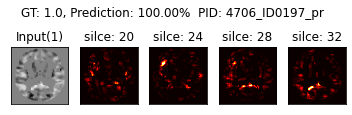



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000271222204901278
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00010281268623657525
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019712049106601626
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002221909089712426


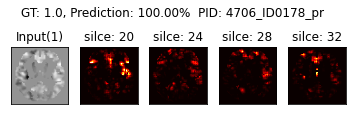



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00022984195675235242
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00017844175454229116
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002673306444194168
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019323021115269512


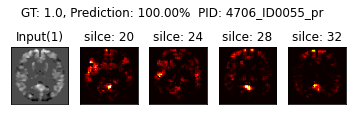



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00012682592205237597
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00018104143964592367
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00013126926205586642
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00029300220194272697


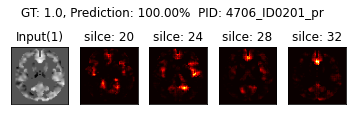



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00042635397403500974
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00022136795450933278
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 6.419070268748328e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 7.518515485571697e-05


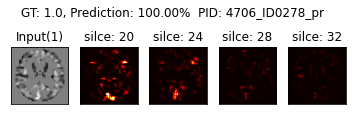



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 6.916104030096903e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 6.841265712864697e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 9.057101124199107e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00015795357467141002


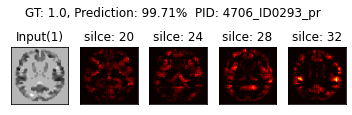



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001819530298234895
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00012036245607305318
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000140269155963324
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019602304382715374


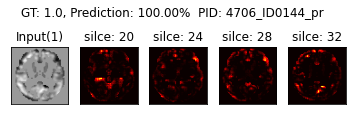



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00021705609105993062
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00037872002576477826
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019459302711766213
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 8.70686344569549e-05


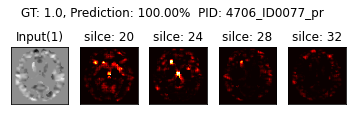



batch_size 8
conv_nd_inverse relevance_in.shape: torch.Size([8, 512, 4, 4, 4])
relevance_out.shape: torch.Size([8, 256, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 256, 4, 4, 4])
relevance_out.shape: torch.Size([8, 128, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 128, 8, 8, 8])
relevance_out.shape: torch.Size([8, 64, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 64, 8, 8, 8])
relevance_out.shape: torch.Size([8, 32, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 32, 16, 16, 16])
relevance_out.shape: torch.Size([8, 16, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 16, 16, 16, 16])
relevance_out.shape: torch.Size([8, 8, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 8, 32, 32, 32])
relevance_out.shape: torch.Size([8, 1, 64, 64, 64])
evidence_for_class: (1, 8, 1, 64, 64, 64)
prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0007528011337853968
evidence_

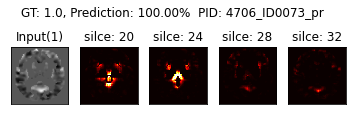



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00034748067264445126
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0003175310848746449
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00012213326408527792
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00018027896294370294


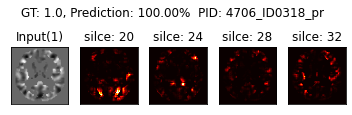



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019260920817032456
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00018718934734351933
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00014030974125489593
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00021631273557431996


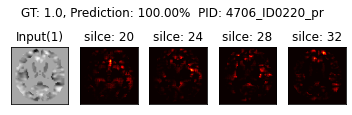



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00023715851421002299
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019510125275701284
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00038788793608546257
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0004667635657824576


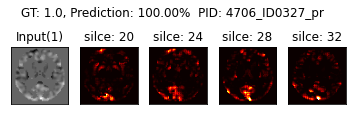



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0005533328512683511
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00038555730134248734
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002978775301016867
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00016537359624635428


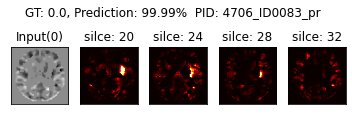



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00017320069309789687
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00020073089399375021
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00021632027346640825
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00040826998883858323


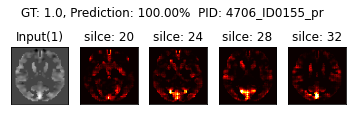



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 1.1275244105490856e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 4.264670678821858e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 2.637965053509106e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 2.7700889404513873e-06


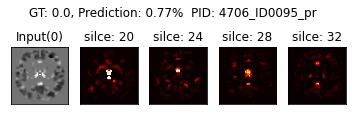



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001453635486541316
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000248517346335575
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00015798097592778504
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 9.356884402222931e-05


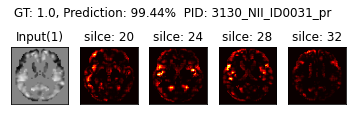



batch_size 8
conv_nd_inverse relevance_in.shape: torch.Size([8, 512, 4, 4, 4])
relevance_out.shape: torch.Size([8, 256, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 256, 4, 4, 4])
relevance_out.shape: torch.Size([8, 128, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 128, 8, 8, 8])
relevance_out.shape: torch.Size([8, 64, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 64, 8, 8, 8])
relevance_out.shape: torch.Size([8, 32, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 32, 16, 16, 16])
relevance_out.shape: torch.Size([8, 16, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 16, 16, 16, 16])
relevance_out.shape: torch.Size([8, 8, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 8, 32, 32, 32])
relevance_out.shape: torch.Size([8, 1, 64, 64, 64])
evidence_for_class: (1, 8, 1, 64, 64, 64)
prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001831508125178516
evidence_

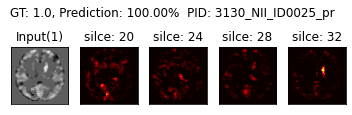



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 8.386380613956135e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 1.0968194601446157e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 1.651980369388184e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 2.3732177396595944e-06


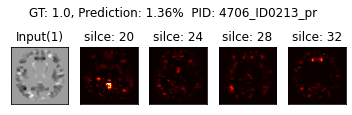



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000569916854146868
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00027065229369327426
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00016214465722441673
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 6.948282680241391e-05


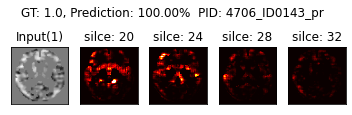



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0004133366164751351
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00035642122384160757
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00022139707289170474
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00041158642852678895


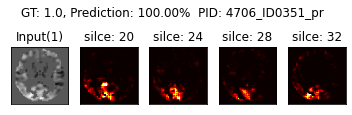



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0006830397178418934
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000720746349543333
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0004269513883627951
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00033652110141701996


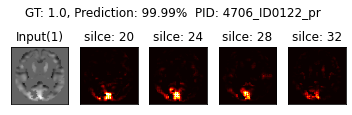



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00013983427197672427
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00020359299378469586
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 9.567007509758696e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00013963461969979107


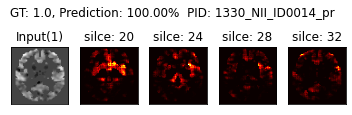



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 1.6626821661702706e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 1.8293852690476342e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 3.2800924145703902e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 3.934991582354996e-06


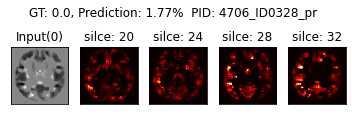



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 8.135774260153994e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 6.397073593689129e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 8.96271230885759e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00010824383207364008


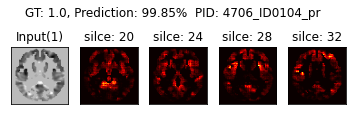



batch_size 8
conv_nd_inverse relevance_in.shape: torch.Size([8, 512, 4, 4, 4])
relevance_out.shape: torch.Size([8, 256, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 256, 4, 4, 4])
relevance_out.shape: torch.Size([8, 128, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 128, 8, 8, 8])
relevance_out.shape: torch.Size([8, 64, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 64, 8, 8, 8])
relevance_out.shape: torch.Size([8, 32, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 32, 16, 16, 16])
relevance_out.shape: torch.Size([8, 16, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 16, 16, 16, 16])
relevance_out.shape: torch.Size([8, 8, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 8, 32, 32, 32])
relevance_out.shape: torch.Size([8, 1, 64, 64, 64])
evidence_for_class: (1, 8, 1, 64, 64, 64)
prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001624706492293626
evidence_

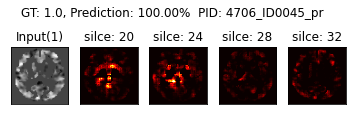



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00010491855209693313
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00013517886691261083
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 9.383822180097923e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00011286211520200595


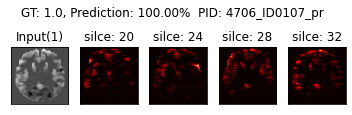



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00021587248193100095
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001971158926608041
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001028364131343551
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 6.422186561394483e-05


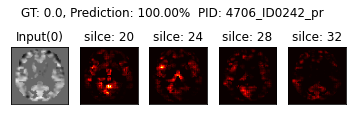



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0004232685605529696
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00022861645265948027
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001598052040208131
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 7.804331835359335e-05


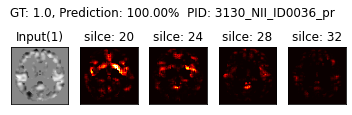



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00026498432271182537
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019495510787237436
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00028076424496248364
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 9.882340964395553e-05


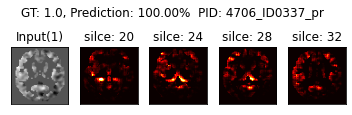



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 5.3388666856335476e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 8.45013273647055e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001296184491366148
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00012021337170153856


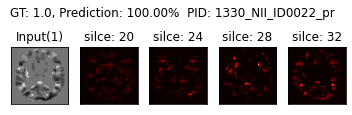



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002728971594478935
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0009391654166392982
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00030545523623004556
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00010819441376952454


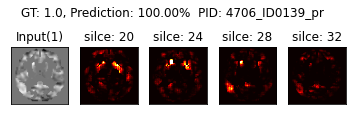



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0003008390194736421
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002773163141682744
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00031184652470983565
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00031120996573008597


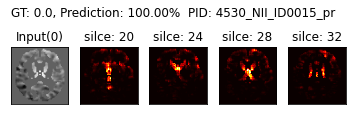



batch_size 8
conv_nd_inverse relevance_in.shape: torch.Size([8, 512, 4, 4, 4])
relevance_out.shape: torch.Size([8, 256, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 256, 4, 4, 4])
relevance_out.shape: torch.Size([8, 128, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 128, 8, 8, 8])
relevance_out.shape: torch.Size([8, 64, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 64, 8, 8, 8])
relevance_out.shape: torch.Size([8, 32, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 32, 16, 16, 16])
relevance_out.shape: torch.Size([8, 16, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 16, 16, 16, 16])
relevance_out.shape: torch.Size([8, 8, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 8, 32, 32, 32])
relevance_out.shape: torch.Size([8, 1, 64, 64, 64])
evidence_for_class: (1, 8, 1, 64, 64, 64)
prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0007631873013451695
evidence_

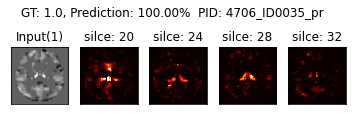



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000316773250233382
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001761853345669806
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00011248164810240269
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00012841279385611415


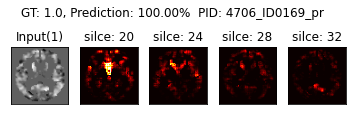



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00016937112377490848
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002377792407060042
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019616459030658007
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002375618350924924


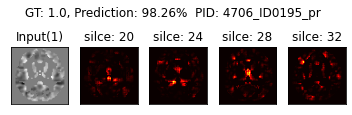



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0006638257182203233
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0004632111522369087
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00038170916377566755
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00027838628739118576


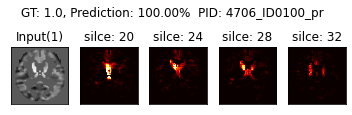



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0006969587411731482
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001477240730309859
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00011144273594254628
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001388203090755269


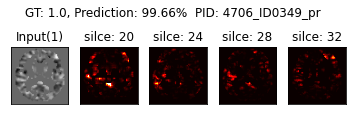



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0006760396063327789
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0003120954497717321
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00036937330150976777
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000261832115938887


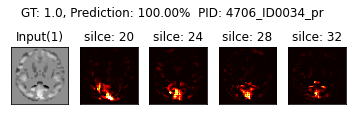



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00029249396175146103
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00017355747695546597
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00011739136243704706
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00013928984117228538


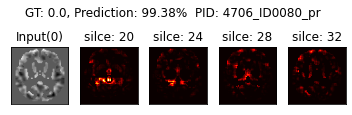



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 1.3331636239399813e-07
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 3.144589015846577e-07
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 3.362533220752084e-07
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 1.4699030259635038e-07


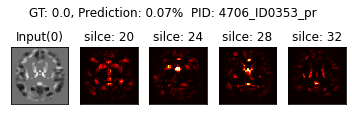



batch_size 8
conv_nd_inverse relevance_in.shape: torch.Size([8, 512, 4, 4, 4])
relevance_out.shape: torch.Size([8, 256, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 256, 4, 4, 4])
relevance_out.shape: torch.Size([8, 128, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 128, 8, 8, 8])
relevance_out.shape: torch.Size([8, 64, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 64, 8, 8, 8])
relevance_out.shape: torch.Size([8, 32, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 32, 16, 16, 16])
relevance_out.shape: torch.Size([8, 16, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 16, 16, 16, 16])
relevance_out.shape: torch.Size([8, 8, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 8, 32, 32, 32])
relevance_out.shape: torch.Size([8, 1, 64, 64, 64])
evidence_for_class: (1, 8, 1, 64, 64, 64)
prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002972641959786415
evidence_

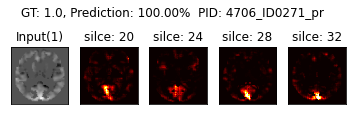



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00022190851450432092
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001815991272451356
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00026148094912059605
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019359758880455047


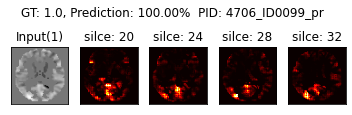



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002445781428832561
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0003872145025525242
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002102065336657688
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0003170582640450448


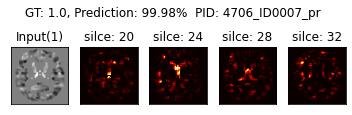



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0006406931788660586
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00022549084678757936
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00023244410112965852
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0003298675292171538


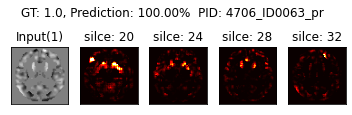



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 8.189700747607276e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 7.583714614156634e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00013212510384619236
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00016791405505500734


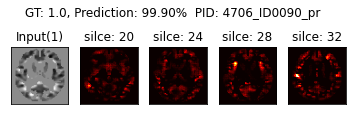



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 7.427812670357525e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00010060154454549775
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0001898418995551765
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00010843222844414413


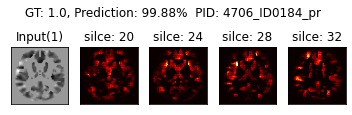



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00030162217444740236
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0008935286314226687
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0003235886397305876
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00026408949634060264


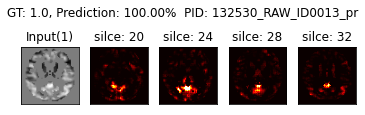



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0005046704900451005
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00016942711954470724
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00013704458251595497
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00016111657896544784


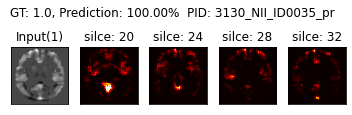



batch_size 8
conv_nd_inverse relevance_in.shape: torch.Size([8, 512, 4, 4, 4])
relevance_out.shape: torch.Size([8, 256, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 256, 4, 4, 4])
relevance_out.shape: torch.Size([8, 128, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([8, 128, 8, 8, 8])
relevance_out.shape: torch.Size([8, 64, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 64, 8, 8, 8])
relevance_out.shape: torch.Size([8, 32, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([8, 32, 16, 16, 16])
relevance_out.shape: torch.Size([8, 16, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 16, 16, 16, 16])
relevance_out.shape: torch.Size([8, 8, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([8, 8, 32, 32, 32])
relevance_out.shape: torch.Size([8, 1, 64, 64, 64])
evidence_for_class: (1, 8, 1, 64, 64, 64)
prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00012094809062546119
evidence

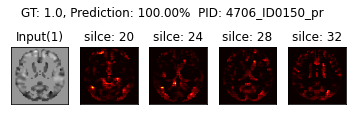



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00016280148702207953
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00017656640557106584
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00012866262113675475
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00015178922330960631


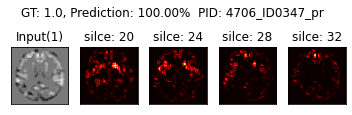



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 6.35624019196257e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000202692361199297
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00011251441173953936
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 7.883308717282489e-05


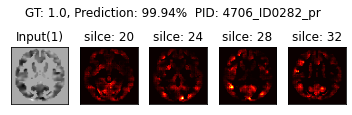



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00014674532576464117
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00019708243780769408
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00031399817089550197
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000161031712195836


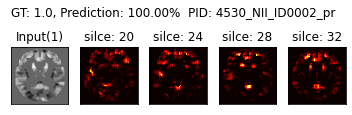



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 4.1642058931756765e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 7.433167047565803e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 9.567985398462042e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 3.600801937864162e-05


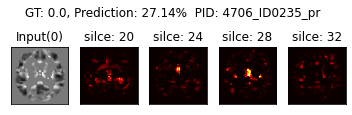



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 1.6728963601053692e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 2.7508046969160205e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 3.2284826829709345e-06
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 4.967741347172705e-07


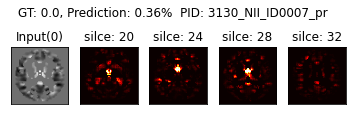



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0003043910546693951
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 8.957365207606927e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00021900467982050031
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0006511503597721457


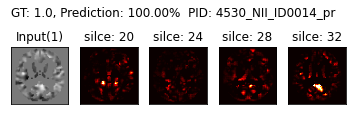



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0006084018386900425
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00011222594184800982
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.000123046018416062
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00029210635693743825


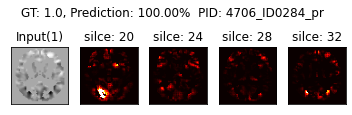



batch_size 3
conv_nd_inverse relevance_in.shape: torch.Size([3, 512, 4, 4, 4])
relevance_out.shape: torch.Size([3, 256, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([3, 256, 4, 4, 4])
relevance_out.shape: torch.Size([3, 128, 4, 4, 4])
conv_nd_inverse relevance_in.shape: torch.Size([3, 128, 8, 8, 8])
relevance_out.shape: torch.Size([3, 64, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([3, 64, 8, 8, 8])
relevance_out.shape: torch.Size([3, 32, 8, 8, 8])
conv_nd_inverse relevance_in.shape: torch.Size([3, 32, 16, 16, 16])
relevance_out.shape: torch.Size([3, 16, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([3, 16, 16, 16, 16])
relevance_out.shape: torch.Size([3, 8, 16, 16, 16])
conv_nd_inverse relevance_in.shape: torch.Size([3, 8, 32, 32, 32])
relevance_out.shape: torch.Size([3, 1, 64, 64, 64])
evidence_for_class: (1, 3, 1, 64, 64, 64)
prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00026832311414182186
evidence

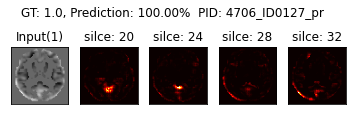



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00010882846981985494
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 4.607906885212287e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 3.471705349511467e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 2.4928251150413416e-05


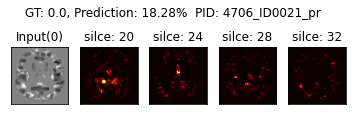



prediction: (1, 1, 64, 64, 64)
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.0002081864804495126
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 8.873670594766736e-05
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 0.00010416794975753874
evidence_for_class[0,idx,0,slice_num,...] min, max: 0.0 8.933791832532734e-05


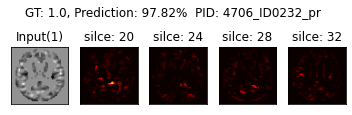

In [ ]:
lrp_result_save_path = '/content/lrp3d_dauh_AD_CN_grey_CV2_results'
lrp_map_save_path = '/content/lrp3d_dauh_AD_CN_grey_CV2_maps'
print(device)
slice_num_list = [20,24,28,32]
prediction_list = []
pid_list = []
truth_list = []
pred_list = []

for (data, target), fname in zip(fold2_valloader, test_fname_list):
    data, target = data.to(device), target.to(device)
    batch_size = int(data.size()[0])
    print("batch_size", batch_size)
    evidence_for_class = []
    
    # for i in range(2):
    model_prediction, input_relevance_values = inn_model.innvestigate(in_tensor=data)
    evidence_for_class.append(input_relevance_values)
        
    evidence_for_class = np.array([elt.numpy() for elt in evidence_for_class])
    print("evidence_for_class:", evidence_for_class.shape) # (#class, B, Channel, D, H, W) = (1, B, 1, 64, 64, 64)
    # print("evidence_for_class min, max:", evidence_for_class.min(), evidence_for_class.item().max())
    # print("model_prediction.shape:", model_prediction.shape) # (B, 1)
    model_prediction_cpu = model_prediction.cpu()
    for idx, (example, f, truth) in enumerate(zip(data, fname, target)):
        prediction = model_prediction_cpu[idx]
        predicted_label = (prediction > 0.5)*torch.ones(1)
        print("prediction:", evidence_for_class[:, idx].shape)
        fig, axes = plt.subplots(1,5,figsize=(6, 2))
        fig.suptitle("GT: {}, ".format(str(truth.item())) + "Prediction: " + "{0:.2f}".format(100*prediction[0]) + "% " + " PID: " + str(f[32:-10]))
        vmin = np.percentile(evidence_for_class[:, idx], 50)
        vmax = np.percentile(evidence_for_class[:, idx], 99.9)
        example_cpu = example[0].cpu()
        
        axes[0].xaxis.set_visible(False)
        axes[0].yaxis.set_visible(False)
        axes[0].imshow(example_cpu[31], cmap="gist_gray")
        axes[0].set_title("Input(" + str(int(target[idx])) + ")")
        pid_list.append(f)
        truth_list.append(truth.item())
        pred_list.append(prediction[0])
        for i, slice_num in enumerate(slice_num_list):
            axes[i+1].xaxis.set_visible(False)
            axes[i+1].yaxis.set_visible(False)
            axes[i+1].imshow(evidence_for_class[0,idx,0,slice_num,...], vmin=vmin, vmax=vmax, cmap="hot")
            print("evidence_for_class[0,idx,0,slice_num,...] min, max:", evidence_for_class[0,idx,0,slice_num,...].min().item(), evidence_for_class[0,idx,0,slice_num,...].max().item())
            axes[i+1].set_title("silce: {}".format(slice_num))
        prediction_list.append(100*prediction[0].item())  
        plt.savefig(os.path.join(lrp_result_save_path, f + '_lrp_results.png'))
        np.save(os.path.join(lrp_map_save_path, f + '_npy_target.npy'), evidence_for_class[:, idx])
        plt.show()
        print('\n')
    # break
import pandas as pd
pred_results_dict = {'pid': pid_list, 'truth': truth_list, 'pred': pred_list}
df = pd.DataFrame(data=pred_results_dict)
df.to_excel("pred_results.xlsx")